In [146]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
num = "7g"
import os
for name in os.listdir('template'):
    if name.endswith('.png'):
        img = cv2.imread(f'template/{name}', 0)
        img = cv2.resize(img, (300, 400))
        plt.imsave(f'template/{name}', img, cmap='gray')


# img = cv2.imread(f'template/{num}_template.png', 0)
# img = cv2.flip(img, 0)
# img = cv2.flip(img, 1)
# img = cv2.resize(img, (300, 400))
# plt.imsave(f'template/{num}_template.png', img, cmap='gray')

Getting card: dataset/R4-4.jpg


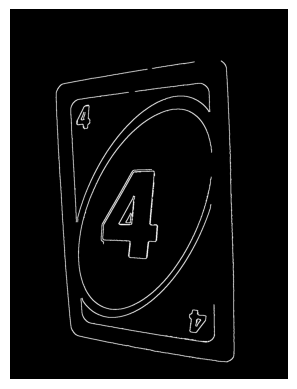

In [234]:
def get_card():
    suit = np.random.choice(['R', 'B', 'G', 'Y'])
    # suit = "Y"
    if suit == 'W':
        num = np.random.choice(['1', '2'])
    else:
        num = np.random.choice(['0', '1', '2', 
                                # '3', '4', '5',
                                #  '6', '7', '8', '9',
                                #  'd', 's', 'r'
                                 ])
    num = '4'
    suit = 'R'
    img_num = 4
    # img_num = 6
    img_path = f'dataset/{suit}{num}-{img_num}.jpg'
    print(f'Getting card: {img_path}')
    return cv2.imread(img_path)


image = get_card()

# Function to rotate the image 90 degrees clockwise
def rotate_image(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)


if image is None:
    print("Error: Unable to load image!")
else:
    # Get the dimensions of the image (height, width, channels)
    height, width = image.shape[:2]

    # Check if the height (length) is greater than the width (breadth)
    if height < width:
        image = rotate_image(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 30)
edges = cv2.Canny(blurred, 50, 150)
edges = cv2.dilate(edges, None, iterations=1)

plt.axis('off')
plt.imshow(edges, cmap='gray')

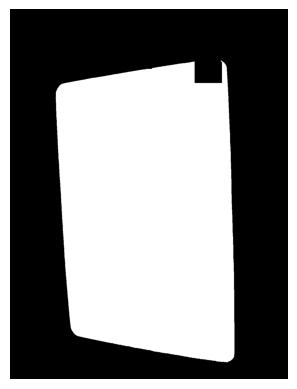

In [235]:
def fill_card(img):
    ksize = np.random.choice([3, 5, 7])
    kernel = np.ones((ksize, ksize), np.uint8)
    iter_ = 15
    img = cv2.dilate(img, kernel, iterations=iter_)
    img = cv2.erode(img, kernel, iterations=iter_)

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filled_image = img.copy()
    i = 0
    for contour in contours:
        cv2.fillPoly(filled_image, [contour], (255, 255, 255))
        i += 1
    return filled_image

filled_card = edges.copy()
for i in range(5):
    filled_card = fill_card(filled_card)

plt.axis('off')
plt.imshow(filled_card, cmap='gray')

In [236]:
contours, _ = cv2.findContours(filled_card, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and take the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Approximate the contour to a polygon
for contour in contours:
    new_img = image.copy()
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    print(f"Number of vertices: {len(approx)}")

    # if len(approx) != 4:
    #     print("No card found.")
    #     break
    if len(approx) == 4:  # If the contour has 4 vertices, it might be the card
        for ind, point in enumerate(approx):
            # print(f"Point {ind+1}: {point[0]}")
            cv2.circle(new_img, tuple(point[0]), 10, (255, 0, 0), -1)
            cv2.putText(new_img, f"{ind}", tuple(point[0]), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 2)
            print(f"Point {ind}: {point[0]}")
        points = approx.reshape((4, 2))
        points = np.array(sorted(points, key=lambda x: x[0]))
        for i in range(4):
            # Get endpoints of each side
            x1, y1 = points[i]
            x2, y2 = points[(i+1) % 4]

            # Equation of the line: Ax + By + C = 0
            A = y2 - y1
            B = x1 - x2
            C = x2 * y1 - x1 * y2

            cv2.line(new_img, tuple(points[i]), tuple(points[(i+1) % 4]), (0, 255, 0), 2)

            print(f"Line {i+1}: {A}x + {B}y + {C} = 0")
        plt.axis('off')
        plt.imshow(new_img)
        break

# Draw the detected cornt found.")

Number of vertices: 6


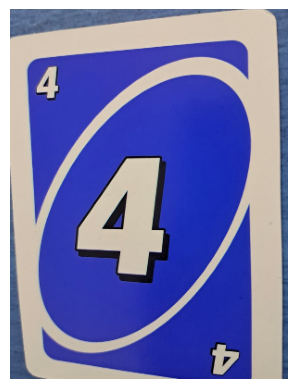

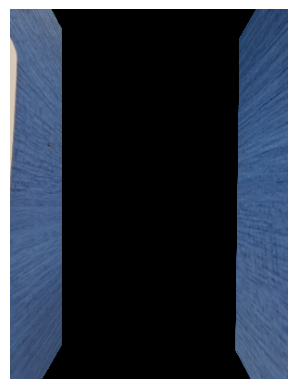

In [237]:
# Crop the imsge to the four corners
def get_cropped_images(img, points):
    corners = np.array([points[0], points[1], points[2], points[3]], dtype=np.float32)

    # Define the dimensions of the output image
    width = 300
    height = 400

    # Define the four corners of the output image
    output_corners1 = np.array([[0, 0], [0, height],[width, 0], [width, height]], dtype=np.float32)
    output_corners2 = np.array([[0, 0], [0, height], [width, height], [width, 0]], dtype=np.float32)

    # Compute the perspective transform matrix
    matrix1 = cv2.getPerspectiveTransform(corners, output_corners1)
    matrix2 = cv2.getPerspectiveTransform(corners, output_corners2)

    # Apply the perspective transform
    output_image1 = cv2.warpPerspective(image, matrix1, (width, height))
    output_image2 = cv2.warpPerspective(image, matrix2, (width, height))

    return output_image1, output_image2

output_image1, output_image2 = get_cropped_images(image, points)
plt.imshow(output_image1)
plt.axis('off')
plt.show()
plt.axis('off')
plt.imshow(output_image2)
plt.show()

In [238]:
def get_zoomed_image(img):
    return img[50:350, 25:275]

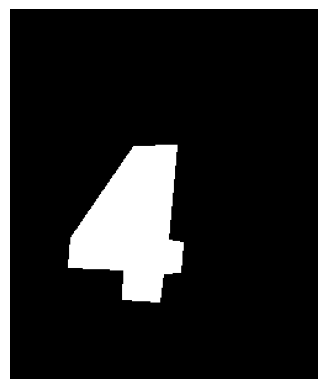

In [239]:
def skeletonize_number(img):
    # Apply edge detection
    edges = cv2.Canny(img, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Assume the largest contour is the card
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to a quadrilateral
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    mask = np.zeros_like(img)
    cv2.drawContours(mask, [approx], -1, (255, 255, 255), -1)

    return mask

def get_skeletonized_image(output_image1, output_image2):
    for img in [output_image1, output_image2]:
        img = get_zoomed_image(img)
        skeletonized = skeletonize_number(img)
        # Print the percentage of white pixels in the image
        percentage_white = np.sum(skeletonized == 255) / np.prod(skeletonized.shape) * 100
        if percentage_white > 5:
            img = skeletonized.mean(axis=2).astype(np.uint8)
            return img
    return np.zeros(skeletonized.shape[:2])

skeletonized_image = get_skeletonized_image(output_image1, output_image2) 
plt.axis('off') 
plt.imshow(skeletonized_image, cmap='gray')      

In [206]:
def get_templates():
    templates = {}
    for i in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'd', 'r', 's']:
        template = cv2.imread(f'template/{i}_template.png', cv2.IMREAD_GRAYSCALE)
        # Binary thresholding
        _, template = cv2.threshold(template, 127, 255, cv2.THRESH_BINARY)
        templates[i] = template
    return templates

In [207]:
def match_template(img):
    templates = get_templates()

    results = {}
    for i, template in templates.items():
        results[i] = []

    if np.all(skeletonized_image == 0):
        return results

    for i in range(4):
        img_copy = img.copy()
        hflip = i%2
        vflip = i//2
        if hflip:
            img_copy = cv2.flip(img_copy, 1)
        if vflip:
            img_copy = cv2.flip(img_copy, 0)

        for i, template in templates.items():
            res = cv2.matchTemplate(img_copy, template, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            results[i].append(max_val)
        return results


results = match_template(skeletonized_image)

# Print the number with the highest match score
number = {}
for i, scores in results.items():
    number[i] = max(scores) if scores else 0

# Sort the numbers by match score
number = sorted(number.items(), key=lambda x: x[1], reverse=True)
if number[0][1] < 0.5:
    print("No number detected.")
else:   
    print(f"Detected number: {number[0][0]}")
    print(f"Detected number: {number[1][0]}")
    print(f"Detected number: {number[2][0]}")


Detected number: 4
Detected number: 9
Detected number: 0


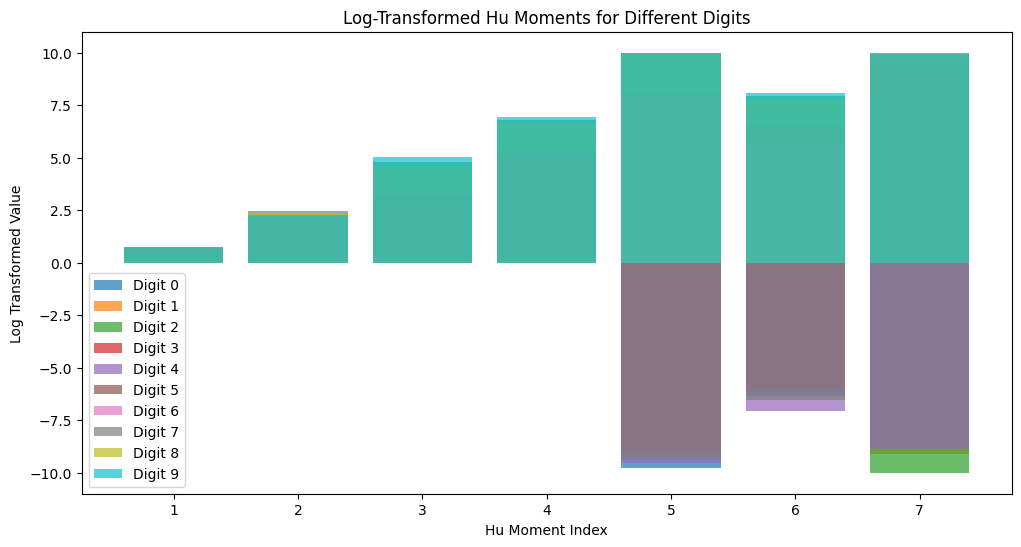

In [208]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_hu_moments(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image (if not already binary)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute Hu moments
    moments = cv2.moments(largest_contour)
    hu_moments = cv2.HuMoments(moments).flatten()

    return hu_moments

def plot_hu_moments(digit_hu_moments):
    plt.figure(figsize=(12, 6))

    for digit, moments in digit_hu_moments.items():
        # Log-transform the Hu moments for better visualization
        log_hu_moments = -np.sign(moments) * np.log10(np.abs(moments) + 1e-10)
        plt.bar(range(1, 8), log_hu_moments, alpha=0.7, label=f'Digit {digit}')

    plt.xlabel('Hu Moment Index')
    plt.ylabel('Log Transformed Value')
    plt.title('Log-Transformed Hu Moments for Different Digits')
    plt.legend()
    plt.show()

# Example: Calculate and plot Hu moments for digits 0-9
digit_hu_moments = {}
for digit in range(10):
    image_path = f"dataset/R{digit}-1.jpg"  # Replace with the path to your digit images
    hu_moments = calculate_hu_moments(image_path)
    digit_hu_moments[digit] = hu_moments

plot_hu_moments(digit_hu_moments)


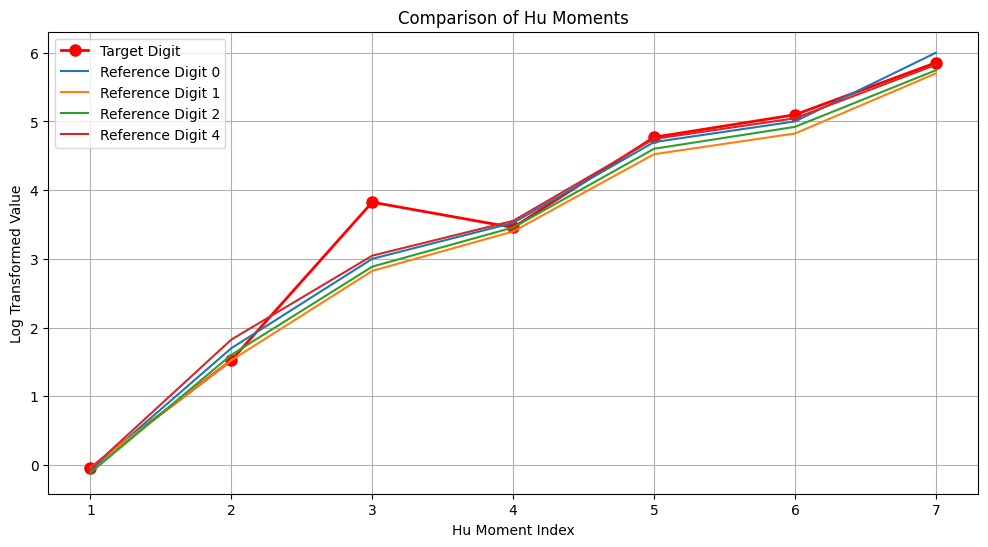

The identified digit is: 1


In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Example reference Hu moments for digits (replace with actual values)
reference_hu_moments = {
    0: [1.2, 0.02, 0.001, 0.0003, 0.00002, 0.00001, 0.000001],
    1: [1.1, 0.03, 0.0015, 0.0004, 0.00003, 0.000015, 0.000002],
    2: [1.3, 0.025, 0.0013, 0.00035, 0.000025, 0.000012, 0.0000018],
    4: [1.15, 0.015, 0.0009, 0.00028, 0.000018, 0.000009, 0.0000015]
}

# Target Hu moments for an unknown number (replace with actual values)
target_hu_moments = [1.1, 0.03, 0.00015, 0.00035, 0.000017, 0.000008, 0.0000014]

def plot_hu_moments_comparison(target_hu_moments, reference_hu_moments):
    plt.figure(figsize=(12, 6))

    # Log-transform the Hu moments for better visualization
    log_target_hu = -np.sign(target_hu_moments) * np.log10(np.abs(target_hu_moments) + 1e-10)
    plt.plot(range(1, 8), log_target_hu, 'ro-', label='Target Digit', linewidth=2, markersize=8)

    # Plot reference digits for comparison
    for digit, moments in reference_hu_moments.items():
        log_hu = -np.sign(moments) * np.log10(np.abs(moments) + 1e-10)
        plt.plot(range(1, 8), log_hu, label=f'Reference Digit {digit}')

    plt.xlabel('Hu Moment Index')
    plt.ylabel('Log Transformed Value')
    plt.title('Comparison of Hu Moments')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_hu_moments_comparison(target_hu_moments, reference_hu_moments)
def identify_digit(target_hu_moments, reference_hu_moments):
    distances = {}
    # Convert target_hu_moments to a NumPy array
    target_hu_moments = np.array(target_hu_moments)

    for digit, moments in reference_hu_moments.items():
        # Convert each reference moment list to a NumPy array
        moments = np.array(moments)
        # Compute the Euclidean distance
        distances[digit] = np.linalg.norm(target_hu_moments - moments)

    # Return the digit with the smallest distance
    return min(distances, key=distances.get)

# Example usage
digit = identify_digit(target_hu_moments, reference_hu_moments)
print(f"The identified digit is: {digit}")
